In [6]:
import src.dependencies.injector as sdi
from src.shared.logger_factory import LoggerFactory
from src.process.data_cleaning.data_cleaning_distributions import jaccard_similarity
from src.shared.utils import get_project_root
from src.model.cluster import Cluster
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import os, re, pickle

log = LoggerFactory.logger(__name__)
DEFAULT_PATH = str(get_project_root()) + \
    "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

In [7]:
injector = sdi.Injector.get_injector_from_file(DEFAULT_PATH)
process_module = injector.get_process_module()
dao_module = injector.get_dao_module()
user_activity_getters = {
    "friends": dao_module.get_user_activity_getter(user_activity="friends"),
    "user retweets": dao_module.get_user_activity_getter(user_activity="user retweets"),
    "user retweets ids": dao_module.get_user_activity_getter(user_activity="user retweets ids")
}
local_neighbourhood_getter = dao_module.get_local_neighbourhood_getter(user_activity="user retweets")
user_getter = dao_module.get_user_getter()
user_friend_getter = dao_module.get_user_friend_getter()

def get_user_activities(user_id: str, user_activity: str):
    activities = user_activity_getters[user_activity].get_user_activities(user_id)
    if len(activities) == 0:
        return None
    else:
        return activities

In [34]:
seed_user_name = "chessable"
seed_user_id = user_getter.get_user_by_screen_name(seed_user_name).id
# Load cluster

with open(f"./graph_data/selected_clusters_{seed_user_id}_ww.pkl", "rb") as f:
    cluster, top_10_users = pickle.load(f)

# Print cluster users
for cluster in [cluster]:
    users = [user_getter.get_user_by_id(user).screen_name for user in cluster.users]
    log.info(users)

2023-07-16 21:51:20 - __main__ - INFO - ['Klitschko', 'CSQpod', 'ChessbaseIndia', 'blackatlantic', 'natesolon', 'ChampChessTour', 'ChessProblem', 'chessable', 'EduIturri', 'rey_enigma', 'DGukesh', 'NealBruceBC', 'gmcanty', 'penguingm1', 'Lona_Chess', 'Tunde_OD', 'tatianafloreswr', 'srinathchess', 'andrewlbeaton', 'ArjunErigaisi', 'Gmasterg4', 'itherocky', 'EugenePerel', 'rainnwilson', 'ForwardChess', 'adhibanchess', 'romain_edouard', 'rpragchess', 'ddtru', 'SportByFort', 'MrBeast', 'chess_dojo', 'chesscom_no', 'NihalSarin', 'dgriffinchess', 'agadmator', 'Jesse_Feb', 'Bennyficial1', 'Braden_Laughlin', 'aicfchess', 'suryachess64', 'sethuramanchess', 'chesscom_in', 'chessbrahTV', 'photochess', '2700chess', 'FollowChessApp', 'VCmilyte', 'SabinaFoisor', 'chesspro_ru', 'StephenMossGdn', 'GMzhuchen', 'adamraoof', 'Berlin_Endgame', 'HowardStaunton', 'WorldofChess', 'ChessKazakh', 'davidllada', 'KingsHeadchess', 'sagarchess1', 'viditchess', 'chesstutor', 'GrandChessTour', 'chess24com', 'ChrisBi

In [35]:
top_10_users

['FIDE_chess',
 'chesscom_in',
 'ChampChessTour',
 'TarjeiJS',
 'GrandChessTour',
 'itherocky',
 'anishgiri',
 'agadmator',
 'aicfchess',
 'DavidHowellGM']

In [36]:
from src.model.local_neighbourhood import LocalNeighbourhood
import pygraphviz as pgv
import matplotlib.pyplot as plt
import networkx as nx
import src.clustering_experiments.create_social_graph_and_cluster as csgc

def get_refined_sg(cluster, user_activity):
        user_map = {}
        cluster.base_user = str(cluster.base_user)
        neighbourhood = local_neighbourhood_getter.get_local_neighbourhood(cluster.base_user)
        for user in cluster.users:
            user_map[user] = list(set(neighbourhood.get_user_activities(user)).intersection(cluster.users)) if user_activity == 'friends' else neighbourhood.get_user_activities(user)

        #base_user_activities = user_map[str(cluster.base_user)]
        cluster_neighbourhood = \
            LocalNeighbourhood(cluster.base_user, None, user_map, neighbourhood.user_activity)
        cluster_soc_graph = \
            csgc.create_social_graph_from_local_neighbourhood(cluster_neighbourhood, user_activity)
        refined_soc_graph = csgc.refine_social_graph_jaccard_users(cluster.base_user, cluster_soc_graph, cluster_neighbourhood, user_activity,threshold=0.0001, weighted=True)
        return refined_soc_graph.graph, cluster_neighbourhood 

refined_soc_graph, cluster_nbhd = get_refined_sg(cluster, "user retweets")

2023-07-16 21:51:34 - src.model.social_graph.union_social_graph - INFO - Length of list 131
2023-07-16 21:51:34 - src.model.social_graph.union_social_graph - INFO - Length of list after removing unconnected nodes 131
2023-07-16 21:51:34 - src.model.social_graph.union_social_graph - INFO - 11375
2023-07-16 21:51:34 - src.clustering_experiments.create_social_graph_and_cluster - INFO - Refining by Jaccard Similarity:
2023-07-16 21:51:38 - src.clustering_experiments.create_social_graph_and_cluster - INFO - Setting Local Neighbourhood:
2023-07-16 21:51:38 - src.model.social_graph.union_social_graph - INFO - Length of list 131
2023-07-16 21:51:38 - src.model.social_graph.union_social_graph - INFO - Length of list after removing unconnected nodes 131
2023-07-16 21:51:38 - src.model.social_graph.union_social_graph - INFO - 131


In [10]:
def visualize_cluster(highlight_users, save=False, file_name: str = None):
    log.info("Visualizing cluster...")
    flag = True
    if highlight_users[0].isnumeric():
        flag = False
    for node in refined_soc_graph.nodes():
        name = user_getter.get_user_by_id(node).screen_name if flag else node
        if name in highlight_users:
            refined_soc_graph.nodes[node]['color'] = 'r'
        else:
            refined_soc_graph.nodes[node]['color'] = 'b'
    plt.figure(figsize=(20, 20))
    colors = [node[1]['color'] for node in refined_soc_graph.nodes(data=True)]

    pos = nx.spring_layout(refined_soc_graph, k=0.1, seed=1)
    nx.draw_networkx(refined_soc_graph, pos=pos, node_color=colors, node_size=100, with_labels=False, width=0.3)
    if save:
        name = file_name if file_name else "./graph_data/graph_{cluster.base_user}.png"
        plt.savefig(name)
    # plt.show()
    # # Visualize using pygraphviz
    # graph = nx.nx_agraph.to_agraph(refined_soc_graph)
    # # Color red if in top 10, blue otherwise
    # for name in top_10_users:
    #     id = self.user_getter.get_user_by_screen_name(name).id
    #     graph.get_node(id).attr['color'] = 'red'

    # graph.layout(prog='dot')
    # graph.draw(f"cluster_{cluster.base_user}.png")
# visualize_cluster(top_10_users)
#top_10_users


In [11]:
# graph_for_LS = refined_soc_graph.copy().to_undirected()
# nodes = list(graph_for_LS.nodes())
# mapping = {nodes[i]: i for i in range(len(nodes))}
# graph_for_LS = nx.relabel_nodes(graph_for_LS, mapping)

# def reverse_mapping(mapping, values):
#     return [key for key, value in mapping.items() if value in values]

In [12]:
# from src.process.clustering.LocalSearch.LS_algorithm import hierarchical_degree_communities

# D,center_dcd,y_dcd,y_partition,plot_combination_data = hierarchical_degree_communities(graph_for_LS, maximum_tree=True, seed=1)

In [13]:
# More ranking experiments
def get_user_ranks(seed_user_name, cluster, path=DEFAULT_PATH):
    """Returns the top 10 ranked users from the given cluster with the seed id as user's id."""
    def get_user_id(user_name):
        user = user_getter.get_user_by_screen_name(user_name)
        user_id = str(user.id)
        return user_id
    user_id = get_user_id(seed_user_name)
    # apply to all users in cluster
    if not cluster.users[0].isnumeric():
        cluster.users = [get_user_id(user_id) for user_id in cluster.users]
    
    injector = sdi.Injector.get_injector_from_file(path)
    process_module = injector.get_process_module()

    prod_ranker = process_module.get_ranker()
    con_ranker = process_module.get_ranker("Consumption")
    sosu_ranker = process_module.get_ranker("SocialSupport")
    infl1_ranker = process_module.get_ranker("InfluenceOne")
    infl2_ranker = process_module.get_ranker("InfluenceTwo")

    # Second argument is the return of score_users
    # prod_rank, prod = prod_ranker.rank(user_id, cluster)
    # con_rank, con = con_ranker.rank(user_id, cluster)
    sosu_rank, sosu = sosu_ranker.rank(user_id, cluster)
    infl1_rank, infl1 = infl1_ranker.rank(user_id, cluster)
    infl2_rank, infl2 = infl2_ranker.rank(user_id, cluster)

    return sosu, infl1, infl2


In [14]:
def get_intersection_ranking(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    for i in range(1, len(prod_ranking) + 1):
        top_prod = set(prod_ranking[:i])
        top_con = set(con_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        top_infl2 = set(infl2_ranking[:i])
        intersection = top_prod.intersection(
            top_con).intersection(
            top_infl1).intersection(
            top_infl2)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [15]:
def control_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:10]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    return sosu_ranking

In [27]:
def get_new_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Plot histogram of inflence 1 scores
    # fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    # sns.histplot([infl1[x][0] for x in infl1], ax=axs[0], kde=True, bins=20)
    # sns.histplot([infl2[x][0] for x in infl2], ax=axs[1], kde=True, bins=20)
    # axs[0].set_title("Influence One")
    # axs[1].set_title("Influence Two")
    # plt.show()

    sosu_ranking = sosu_ranking[:20]
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in infl1_ranking:
        if len(sosu_ranking) <= 10:
            break
        if user in sosu_ranking:
            sosu_ranking.remove(user)
    # Influence 1 with users in sosu_ranking
    # lst = [infl1[x][0] for x in sosu_ranking]
    # print("Influence 1 scores:", lst)
            
        
    return sosu_ranking

In [17]:
def get_new_avg_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:20]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    avg_infl1_infl2 = {user: min(infl1[user][0], infl2[user][0]) for user in sosu}
    avg_infl1_infl2 = list(sorted(avg_infl1_infl2, key=lambda x: (avg_infl1_infl2[x]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in avg_infl1_infl2:
        if user in sosu_ranking:
            sosu_ranking.remove(user)
        if len(sosu_ranking) == 10:
            break
    return sosu_ranking

In [18]:
def get_new_min_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    top_all = {}
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for i in range(1, len(sosu_ranking) + 1):
        top_sosu = set(sosu_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        intersection = top_sosu.intersection(top_infl1)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break
    
    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [19]:
def get_new_top_avg_intersection_ranking(sosu, infl1, infl2, alpha=0.5):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    top_10_infl1 = set(infl1_ranking[:10])
    users = [user_getter.get_user_by_id(x).screen_name for x in infl1_ranking[:10]]
    log.info(f"Top 10 users: {users}")
    # Average of top_10_infl1
    avg_top_10_infl1 = sum([infl1[x][0] for x in top_10_infl1]) / len(top_10_infl1)
    t = alpha * avg_top_10_infl1
    log.info(f"Threshold is {t}")
    # Remove users if infl1 score is less than t
    for user in infl1_ranking:
        if infl1[user][0] < t:
            if user in sosu_ranking:
                sosu_ranking.remove(user)
                
    return sosu_ranking

In [37]:
# seed_user_name = 'hardmaru'
# cluster =  ['shaneguML', 'ecsquendor', 'MLStreetTalk', 'AndrewLampinen', 'pcastr', 'GaryMarcus', 'ericjang11', 'nathanbenaich', 'JayAlammar', '_joaogui1', 'ykilcher', 'aidangomezzz', 'demishassabis', 'quocleix', 'HochreiterSepp', 'agarwl_', 'andrew_n_carr', 'MeMohanty', 'BlackHC', 'gabepsilon', 'sarahookr', 'natashajaques', 'mmbronstein', 'kerstingAIML', '_sam_sinha_', 'ZoubinGhahrama1', 'wellingmax', 'caglarml', 'bodonoghue85', 'togelius', 'WonderMicky', 'ID_AA_Carmack', 'davidobarber', 'ChrSzegedy', 'brandondamos', 'Luke_Metz', 'LakeBrenden', 'berkeley_ai', 'geoffreyhinton', 'edchi', 'dustinvtran', 'thomaskipf', 'jekbradbury', 'hardmaru', 'CompSciOxford', 'FeryalMP', 'seb_ruder', 'ryan_p_adams', 'svlevine', 'marcgbellemare', 'arkitus', 'FelixHill84', 'woj_zaremba', 'roydanroy', 'JeffDean', 'yeewhye', 'pfau', 'alonamarie', 'Smerity', 'cjmaddison', 'RandomlyWalking', 'TensorFlow', 'sedielem', 'fhuszar', 'scott_e_reed', 'dipanjand', 'kchonyc', 'pabbeel', 'maosbot', 'clmt', 'DeepMind', 'lawrennd', 'johnplattml', 'fchollet', 'DaniloJRezende', 'robertsdionne', 'wooldridgemike', 'hugo_larochelle', 'yaringal', 'yisongyue', '_rockt', 'MirowskiPiotr', 'theophaneweber', 'shakir_za', 'MIT_CSAIL', 'NandoDF', 'Google', 'GoogleAI']
# cluster = Cluster(seed_user_name, cluster)
sosu, infl1, infl2 = get_user_ranks(seed_user_name, cluster)

100%|██████████| 131/131 [00:04<00:00, 27.03it/s]


In [33]:
check_user = 'DeepMind'
id = user_getter.get_user_by_screen_name(check_user).id
print("Social Support: ", sosu[str(id)])

Social Support:  [167.0, 738154]


In [22]:
def find_follower_count(user_list: List[str], respecting_list: List[str] = None):
    res = {user_id: 0 for user_id in user_list}
    users = respecting_list if respecting_list else user_getter.get_all_users()
    for u in users:
        friends = user_friend_getter.get_user_friends_ids(str(u))
        if friends:
            for friend in friends:
                friend = str(friend)
                if friend in res:
                    res[friend] += 1

    # Map user ids to screen names
    res = {user_getter.get_user_by_id(user_id).screen_name: res[user_id] for user_id in res}
    return res

def find_followers_in_cluster(user_list: List[str], cluster: Cluster):
    cluster_users = cluster.users
    return find_follower_count(user_list, cluster_users)

def find_friends_count(user_list: List[str], respecting_list: List[str] = None):
    res = {user_getter.get_user_by_id(user_id).screen_name: 0 for user_id in user_list}

    for name in res:
        id = user_getter.get_user_by_screen_name(name).id
        friends = set(map(str, user_friend_getter.get_user_friends_ids(str(id))))
        res[name] = friends.intersection(set(respecting_list)) if respecting_list else set(user_friend_getter.get_user_friends_ids(str(id)))
        res[name] = len(res[name])

    return res

def find_friends_in_cluster(user_list: List[str], cluster: Cluster):
    cluster_users = cluster.users
    return find_friends_count(user_list, cluster_users)

def retweets_in_common(respecting_list: List[str]):
    # Returns the number of users retweeted at least two users in the respecting list
    if not respecting_list[0].isnumeric():
        respecting_list = [str(user_getter.get_user_by_screen_name(name).id) for name in respecting_list]
    count = 0
    res = set(cluster_nbhd.get_user_activities(respecting_list[0]))
    for user in respecting_list[1:]:
        rtd_users = (set(cluster_nbhd.get_user_activities(user)))
        res = res.intersection(rtd_users)
    return len(res)
# retweets_in_common(top_10_users)
# find_friends_in_cluster([str(user_getter.get_user_by_screen_name("ClementDelangue").id)], cluster)


In [23]:
def summarize_cluster(filename_table: str, cluster, sosu, infl1, infl2):
    # Get top 20 of sosu, infl1, infl2
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:20]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))[:20]
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))[:20]

    # Log users
    users = [user_getter.get_user_by_id(x).screen_name for x in sosu_ranking]
    log.info(f"Sosu top 20: {users}")
    users = [user_getter.get_user_by_id(x).screen_name for x in infl1_ranking]
    log.info(f"Infl1 top 20: {users}")
    users = [user_getter.get_user_by_id(x).screen_name for x in infl2_ranking]
    log.info(f"Infl2 top 20: {users}")

    follower_counts = find_follower_count(sosu_ranking)
    follower_counts_in_cluster = find_followers_in_cluster(cluster.users, cluster)
    friend_counts = find_friends_count(sosu_ranking)
    friend_counts_in_cluster = find_friends_in_cluster(cluster.users, cluster)
    
    avg_follower_count = sum(follower_counts.values()) / len(follower_counts)
    avg_follower_count_in_cluster = sum(follower_counts_in_cluster.values()) / len(follower_counts_in_cluster)
    avg_friend_count = sum(friend_counts.values()) / len(friend_counts)
    avg_friend_count_in_cluster = sum(friend_counts_in_cluster.values()) / len(friend_counts_in_cluster)

    log.info(f"Average follower count: {avg_follower_count}")
    log.info(f"Average follower count in cluster: {avg_follower_count_in_cluster}")
    log.info(f"Average friend count: {avg_friend_count}")
    log.info(f"Average friend count in cluster: {avg_friend_count_in_cluster}")
    visualize_cluster(top_10_users, save=True, file_name=f"./graph_data/top_10_graph_{cluster.base_user}.png")
    visualize_cluster(sosu_ranking, save=True, file_name=f"./graph_data/sosu_graph_{cluster.base_user}.png")

    # Save csv file with user stats
    with open(f"{filename_table}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["user", "sosu", "infl1", "infl2", "followers_in_db", "followers_in_cluster", "friends_in_db", "friends_in_cluster"])
        
        for user in sosu_ranking:
            user_obj = user_getter.get_user_by_id(user)
            name = user_obj.screen_name
            writer.writerow([name,
                            sosu[user][0],
                            infl1[user][0],
                            infl2[user][0],
                            follower_counts[name],
                            follower_counts_in_cluster[name],
                            friend_counts[name],
                            friend_counts_in_cluster[name]])

In [38]:
new_sosu_ranking = get_new_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_sosu_ranking]
log.info(new_sosu_ranking_names)

2023-07-16 21:52:01 - __main__ - INFO - Sosu score cutoff is 169.0
2023-07-16 21:52:01 - __main__ - INFO - ['FIDE_chess', 'chesscom_in', 'ChampChessTour', 'TarjeiJS', 'STLChessClub', 'GrandChessTour', 'itherocky', 'anishgiri', 'agadmator', 'aicfchess']


2023-07-16 21:53:05 - __main__ - INFO - Sosu top 20: ['FIDE_chess', 'chess24com', 'chesscom_in', 'ChesscomLive', 'davidllada', 'ChessbaseIndia', 'ChampChessTour', 'TarjeiJS', 'GMjtis', 'STLChessClub', 'GrandChessTour', 'itherocky', 'chessable', 'ChessKazakh', 'anishgiri', 'agadmator', 'ChessProblem', 'olimpiuurcan', 'aicfchess', 'ECUonline']
2023-07-16 21:53:05 - __main__ - INFO - Infl1 top 20: ['lachesisq', 'london_chess', 'NihalSarin', 'GMGawain', 'penguingm1', 'Macauley64', 'DGukesh', 'DavidHowellGM', 'PlayMagnus', 'TaniaSachdev', 'Agdestein', 'GrandChessTour', '2700chess', 'Rameshchess', 'fins0905', 'NorwayChess', 'ArjunErigaisi', 'fionchetta', 'adhibanchess', 'chesscom_in']
2023-07-16 21:53:05 - __main__ - INFO - Infl2 top 20: ['FIDE_chess', 'chess24com', 'TarjeiJS', 'davidllada', 'GMjtis', 'ChesscomLive', 'ChessbaseIndia', 'ChampChessTour', 'itherocky', 'chesscom_in', 'GrandChessTour', 'STLChessClub', 'agadmator', 'illescasmiguel', 'anishgiri', 'chessable', 'dgriffinchess', 'ches

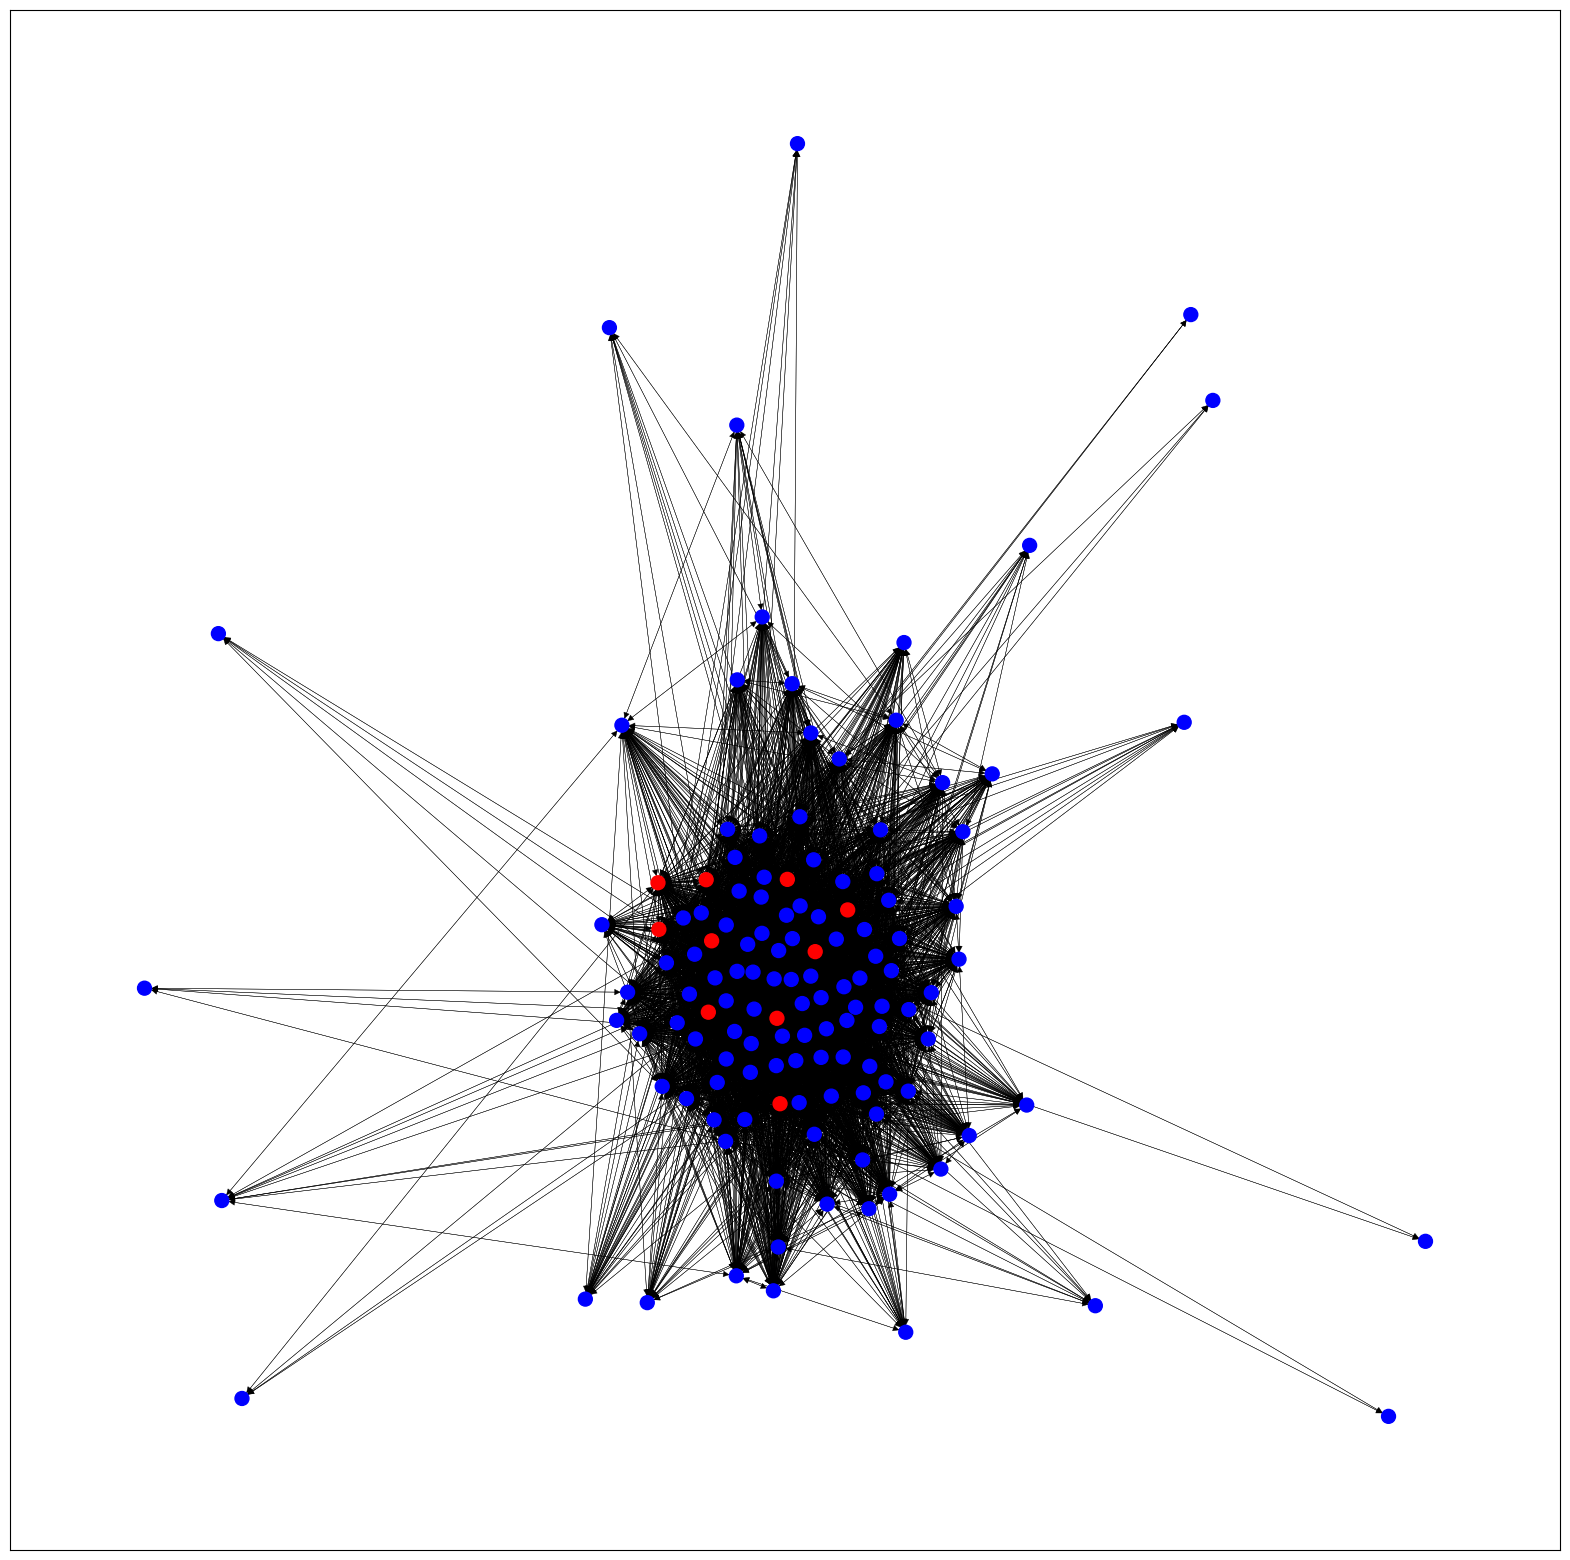

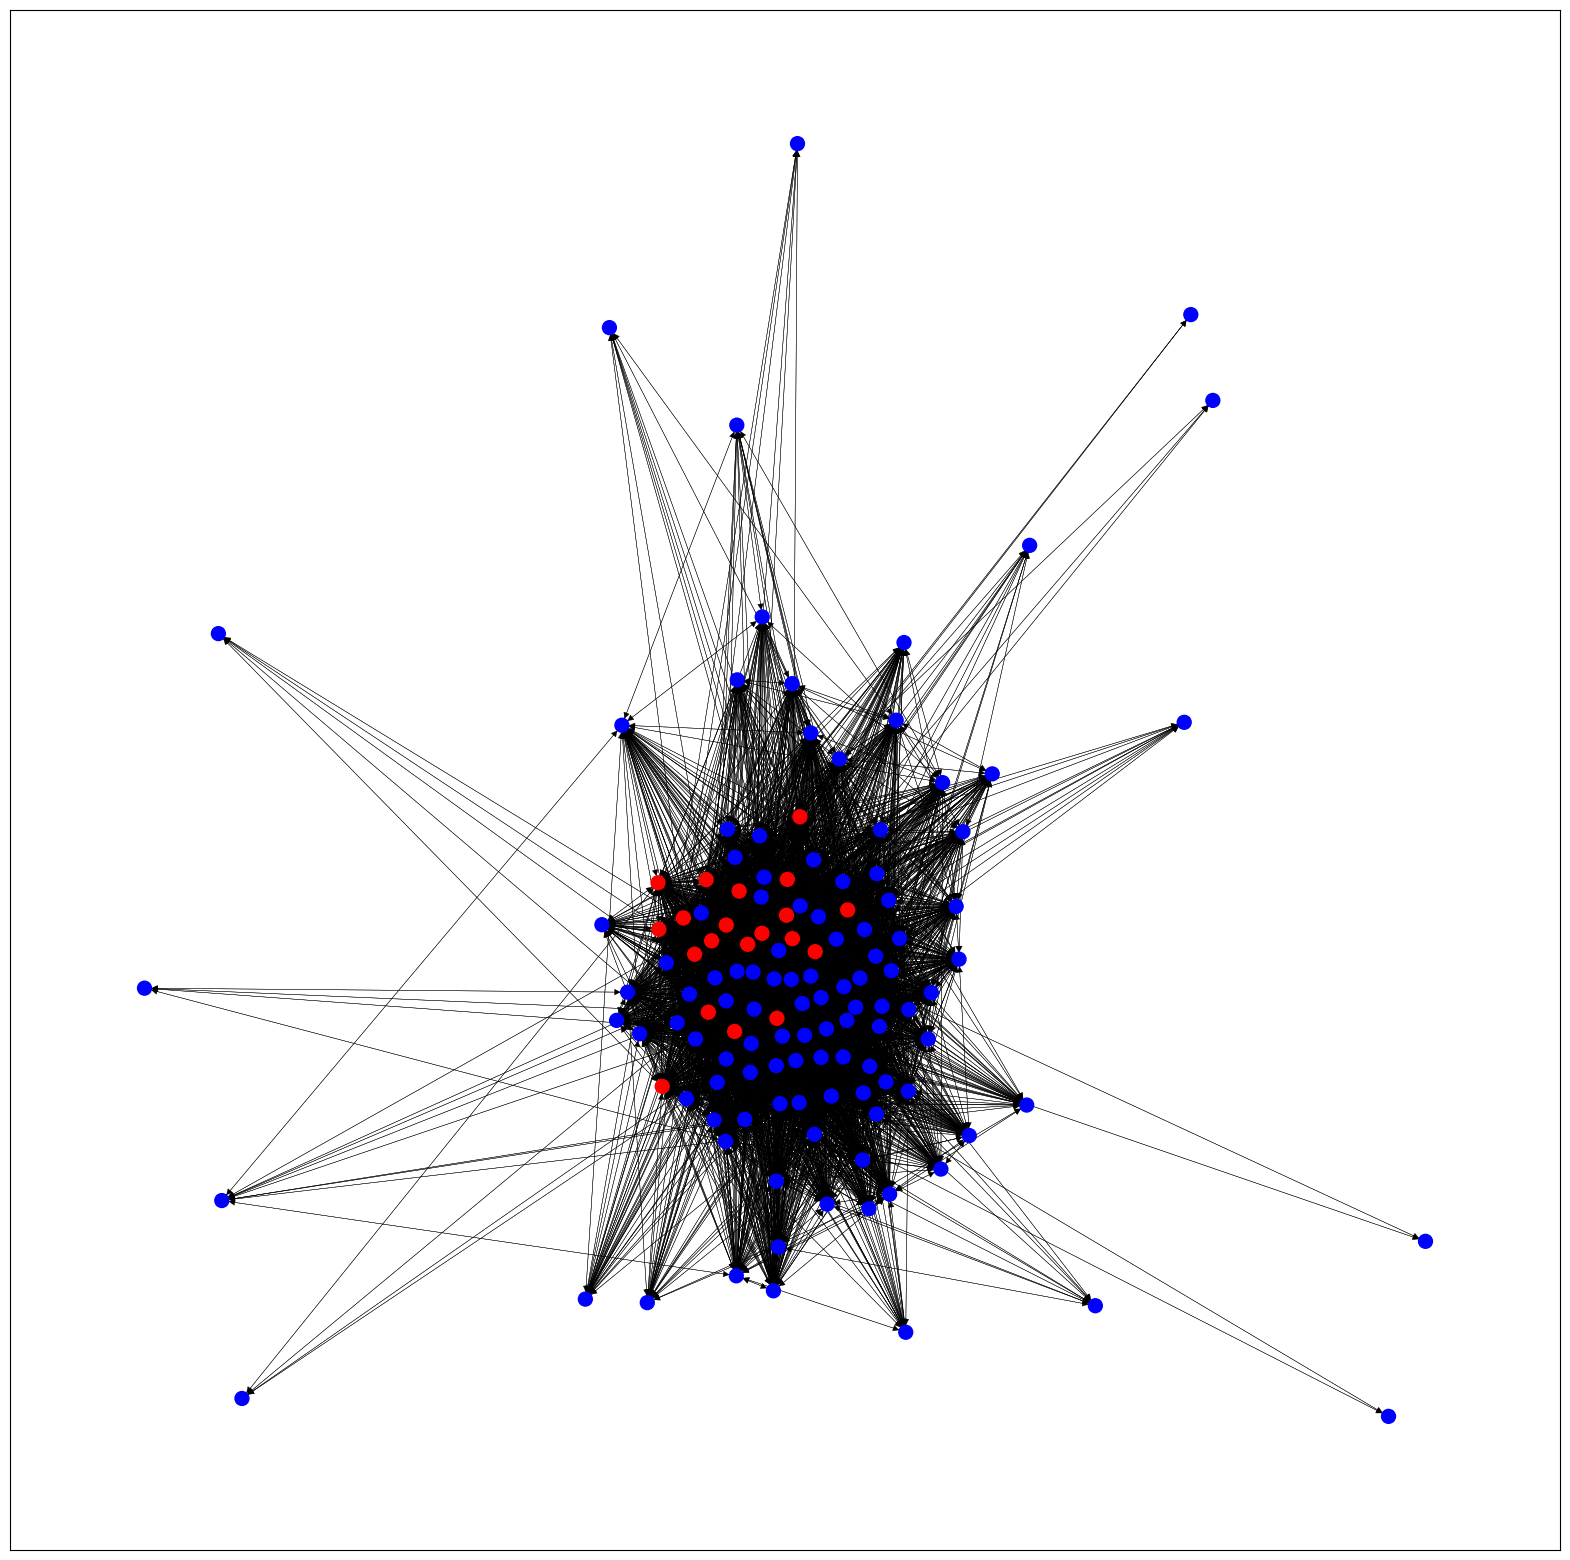

In [39]:
summarize_cluster(f"./graph_data/table_{cluster.base_user}", cluster, sosu, infl1, infl2)

In [82]:
# Loop through all files in ./data that start with "selected_clusters"
def gen_table_from_data(data_path: str):
    for file in os.listdir(data_path):
        filename = os.fsdecode(file)
        if filename.startswith("selected_clusters"):
            with open(f"{data_path}/{filename}", "rb") as f:
                clusters = pickle.load(f)
                # Return the chars after "selected_clusters_"
                name = re.search(r"selected_clusters_(.*)", filename).group(1)
                # Split on the first underscore
                user_id = name.split("_", 1)[0]
                seed_user_name = user_getter.get_user_by_id(user_id).screen_name
                root_csv_name = seed_user_name + "_" + name
                for i, cluster in enumerate(clusters):
                    csv_name = f"./tables/{root_csv_name}_{i+1}"
                    log.info("Tabulating cluster " + str(csv_name))
                    sosu, infl1, infl2, prod, con = get_user_ranks(seed_user_name, cluster)
                    summarize_cluster(csv_name, cluster, sosu, infl1, infl2)

In [83]:
def get_ranking_score_by_screen_name(screen_name: str, score) -> float:
    user_id = user_getter.get_user_by_screen_name(screen_name).id
    print(score[str(user_id)][0])
# get_ranking_score_by_screen_name("hardmaru", sosu)

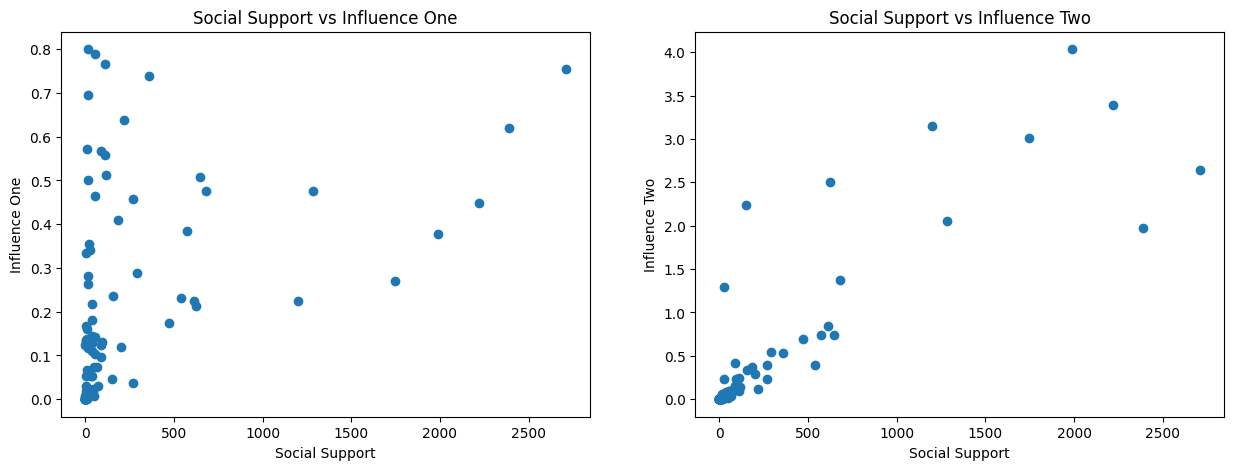

In [84]:
# Plot sosu vs infl1, infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in sosu], [infl1[user][0] for user in sosu])
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in sosu], [infl2[user][0] for user in sosu])
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()

In [85]:
control_sosu_ranking = control_intersection_ranking(sosu, infl1, infl2)
control_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in control_sosu_ranking]
log.info(control_sosu_ranking_names)

2023-07-04 03:01:27 - __main__ - INFO - Sosu score cutoff is 625.0
2023-07-04 03:01:27 - __main__ - INFO - ['chesscom', 'chesscom_in', 'ChesscomLive', 'FIDE_chess', 'chess24com', 'itherocky', 'ChessbaseIndia', 'GrandChessTour', 'aicfchess', 'TarjeiJS']


In [86]:
old_intersection_ranking = get_intersection_ranking(prod, con, infl1, infl2)
old_intersection_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in old_intersection_ranking]
log.info(old_intersection_ranking_names)

2023-07-04 03:01:27 - __main__ - INFO - ['chesscom_in', 'chesscom', 'aicfchess', 'GrandChessTour', 'itherocky', 'ChesscomLive', 'rpragchess', 'anishgiri', 'FIDE_chess', 'DavidHowellGM']


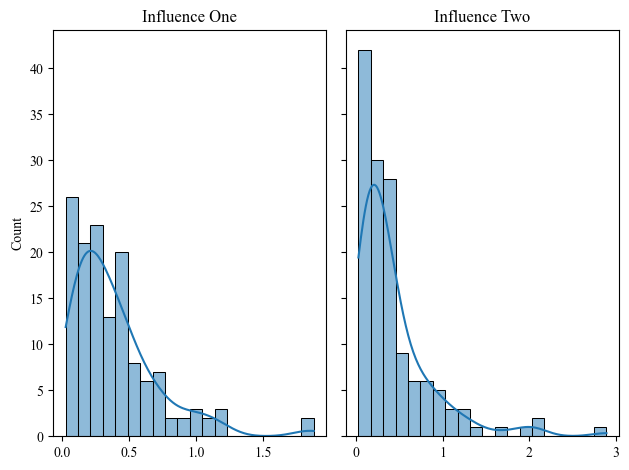

2023-07-16 21:05:14 - __main__ - INFO - Sosu score cutoff is 216.0
2023-07-16 21:05:14 - __main__ - INFO - ['_rockt', 'arankomatsuzaki', 'egrefen', 'hugo_larochelle', 'shakir_za', 'JeffDean', 'brandondamos', 'riedelcastro', 'CohereAI', 'poolio']


Influence 1 scores: [0.5693050910442214, 0.7198612315698178, 0.4397196261682243, 1.0654044750430292, 0.4282968089196463, 0.4836167565325591, 0.47052845528455284, 0.4673913043478261, 0.7434343434343434, 0.7333333333333333]


In [17]:
new_sosu_ranking = get_new_intersection_ranking(sosu, infl1, infl2)
# Print user names
# Diff only mmitchell_ai removed -- better since theyre not a researcher
new_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_sosu_ranking]
log.info(new_sosu_ranking_names)

In [88]:
new_avg_sosu_ranking = get_new_avg_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_avg_sosu_ranking]
log.info(new_avg_sosu_ranking_names)

2023-07-04 03:01:28 - __main__ - INFO - Sosu score cutoff is 199.0
2023-07-04 03:01:28 - __main__ - INFO - ['chesscom', 'chesscom_in', 'ChesscomLive', 'FIDE_chess', 'itherocky', 'GrandChessTour', 'aicfchess', 'anishgiri', 'Rameshchess', 'rpragchess']


In [89]:
new_min_sosu_ranking = get_new_min_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_min_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_min_sosu_ranking]
log.info(new_min_sosu_ranking_names)

2023-07-04 03:01:28 - __main__ - INFO - Sosu score cutoff is 0
2023-07-04 03:01:28 - __main__ - INFO - ['chesscom', 'chesscom_in', 'aicfchess', 'itherocky', 'Rameshchess', 'GrandChessTour', 'rpragchess', 'ChesscomLive', 'GMJuditPolgar', 'anishgiri', 'DavidHowellGM']


In [90]:
new_top_avg_sosu_ranking = get_new_top_avg_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_top_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_top_avg_sosu_ranking]
log.info(new_top_avg_sosu_ranking_names)

2023-07-04 03:01:28 - __main__ - INFO - Top 10 users: ['london_chess', 'sadhwani2005', 'TaniaSachdev', 'chesscom', 'Rameshchess', 'Chesser_22', 'GMJuditPolgar', 'chesscom_in', 'advorkovich', 'adhibanchess']
2023-07-04 03:01:28 - __main__ - INFO - Threshold is 0.347123182331288
2023-07-04 03:01:28 - __main__ - INFO - ['chesscom', 'chesscom_in', 'ChesscomLive', 'FIDE_chess', 'itherocky', 'GrandChessTour', 'aicfchess', 'anishgiri', 'Rameshchess', 'rpragchess', 'GMJuditPolgar', 'DavidHowellGM', 'viditchess', 'TaniaSachdev', 'chessvaishali', 'adhibanchess', 'chessqueen', 'sadhwani2005', 'DivyaDeshmukh05', 'london_chess', 'BCMChess', 'Chesser_22', 'advorkovich']


In [91]:
# Set difference both ways
log.info(set(old_intersection_ranking_names) - set(new_sosu_ranking_names))
log.info(set(new_sosu_ranking_names) - set(new_avg_sosu_ranking_names))
log.info(set(new_avg_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(new_min_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(control_sosu_ranking_names) - set(new_avg_sosu_ranking_names))

2023-07-04 03:01:28 - __main__ - INFO - {'DavidHowellGM', 'FIDE_chess'}
2023-07-04 03:01:28 - __main__ - INFO - {'GMJuditPolgar'}
2023-07-04 03:01:28 - __main__ - INFO - {'FIDE_chess'}
2023-07-04 03:01:28 - __main__ - INFO - {'DavidHowellGM'}
2023-07-04 03:01:28 - __main__ - INFO - {'ChessbaseIndia', 'TarjeiJS', 'chess24com'}


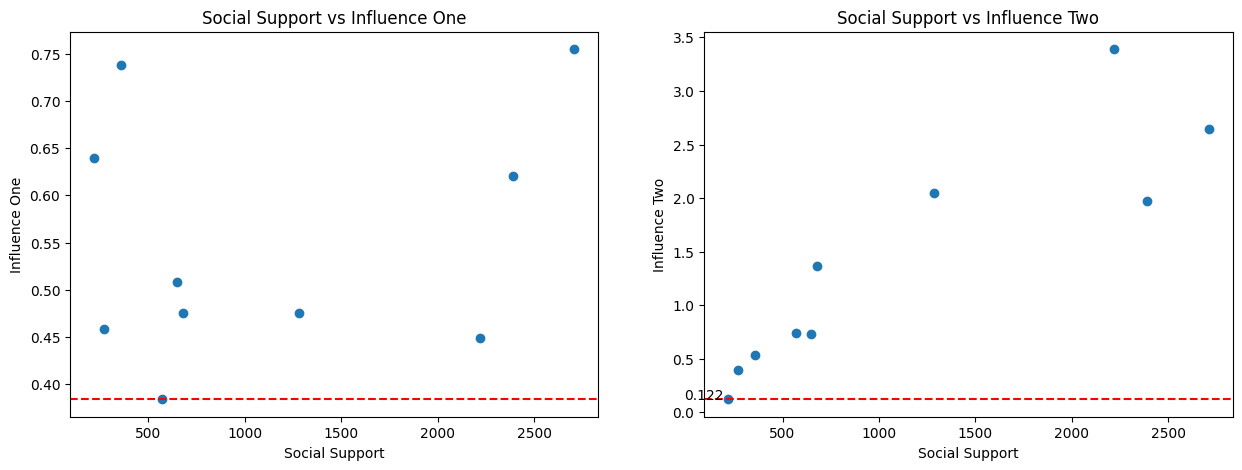

In [92]:
# Plot social support vs infl1 and infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in new_sosu_ranking], [infl1[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl1 score
min1 = min([infl1[user][0] for user in new_sosu_ranking])
ax1.axhline(y=min1, color='r', linestyle='--')
# Show value of min infl1 score
#ax1.text(-8, min1, f"{min1:.3f}")
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in new_sosu_ranking], [infl2[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl2 score
min2 = min([infl2[user][0] for user in new_sosu_ranking])
ax2.axhline(y=min2, color='r', linestyle='--')
# Show value of min infl2 score
ax2.text(-8, min2, f"{min2:.3f}")
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()